In [94]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random


#######################################
### Feature normalization
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size(num_instances, num_features)
        test - test set, a 2D numpy array of size(num_instances, num_features)

    Returns:
        train_normalized - training set after normalization
        test_normalized - test set after normalization
    """
    # TODO
    maxx = train.max(axis=0)
    minx = train.min(axis=0)
    
    # For sake of constant filtering
    cs = minx != maxx
    
    train_filt = train[:,cs]
    
    train_normalized = (train_filt-minx)/(maxx-minx)
    test_normalized = (test-minx)/(maxx-minx)
    return train_normalized, test_normalized



#######################################
### The square loss function
def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the average square loss for predicting y with X*theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D array of size(num_features)

    Returns:
        loss - the average square loss, scalar
    """
    #TODO
    loss = (1/np.shape(X)[0])*np.linalg.norm(X@theta-y)
    return loss


#######################################
### The gradient of the square loss function
def compute_square_loss_gradient(X, y, theta):
    """
    Compute the gradient of the average square loss(as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    #TODO
    grad = (2/np.shape(X)[0])*(X.T@X@theta-X.T@y)
    return grad



#######################################
### Gradient checker
#Getting the gradient calculation correct is often the trickiest part
#of any gradient-based optimization algorithm. Fortunately, it's very
#easy to check that the gradient calculation is correct using the
#definition of gradient.
#See http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
(e_1 =(1,0,0,...,0), e_2 =(0,1,0,...,0), ..., e_d =(0,...,0,1))

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
(J(theta + epsilon * e_i) - J(theta - epsilon * e_i)) /(2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicating whether the gradient is correct or not
    """
    true_gradient = compute_square_loss_gradient(X, y, theta) #The true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    #TODO
    d = np.shape(X)[1]
    E = np.eye(d)
    for i in range(d):
        app = (compute_square_loss(X, y, theta+epsilon*E[i]) - compute_square_loss(X, y, theta-epsilon*E[i]))/(2*epsilon)
        approx_grad[i] = app
        
    dist = np.linalg.norm(true_gradient-approx_grad)
    if dist > tolerance:
        ans= False
    else:
        ans = True
    
    
    return ans


#######################################
### Generic gradient checker
def generic_gradient_checker(X, y, theta, objective_func, gradient_func, 
                             epsilon=0.01, tolerance=1e-4):
    """
    The functions takes objective_func and gradient_func as parameters. 
    And check whether gradient_func(X, y, theta) returned the true 
    gradient for objective_func(X, y, theta).
    Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
    """
    #TODO



#######################################
### Batch gradient descent
def batch_grad_descent(X, y, alpha=0.1, num_step=1000, grad_check=False):
    """
    In this question you will implement batch gradient descent to
    minimize the average square loss objective.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        num_step - number of steps to run
        grad_check - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step) is theta_hist[-1]
        loss_hist - the history of average square loss on the data, 1D numpy array,(num_step+1)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_step + 1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_step + 1)  #Initialize loss_hist
    theta = np.zeros(num_features)  #Initialize theta
    #TODO
    theta_hist[0,:] = theta
    loss_hist[0] = compute_square_loss(X, y, theta)
    for i in range(num_step):
        theta_hist[i+1,:] = theta_hist[i,:] - alpha * compute_square_loss_gradient(X, y, theta_hist[i])
        loss_hist[i+1] = compute_square_loss(X, y, theta_hist[i+1,:])
        check = grad_checker(X, y, theta_hist[i+1,:], epsilon=0.01, tolerance=1e-4)
        if check == True:
            break
    return theta_hist, loss_hist



#######################################
### The gradient of regularized batch gradient descent
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized average square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    #TODO
    grad = (2/np.shape(X)[0])*(X.T@X@theta-X.T@y)+ 2*lambda_reg*theta
    return grad

#######################################
### Regularized batch gradient descent
def regularized_grad_descent(X, y, alpha, lambda_reg, num_step=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        num_step - number of steps to run
    
    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step+1) is theta_hist[-1]
        loss hist - the history of average square loss function without the regularization term, 1D numpy array.
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.zeros(num_features) #Initialize theta
    theta_hist = np.zeros((num_step+1, num_features)) #Initialize theta_hist
    loss_hist = np.zeros(num_step+1) #Initialize loss_hist

    #TODO
    theta_hist[0,:] = theta
    loss_hist[0] = compute_square_loss(X, y, theta)
    for i in range(num_step):
        theta_hist[i+1,:] = theta_hist[i,:] - alpha * compute_regularized_square_loss_gradient(X, y, theta_hist[i,:], lambda_reg)
        loss_hist[i+1] = compute_square_loss(X, y, theta_hist[i+1,:])
#         check = grad_checker(X, y, theta_hist[i+1,:], epsilon=0.01, tolerance=1e-4)
#          if check == False:
#              break
    return theta_hist, loss_hist

    



#######################################
### Stochastic gradient descent
def stochastic_grad_descent(X, y, alpha=0.01, lambda_reg=10**-2, num_epoch=1000, eta0=False):
    """
    In this question you will implement stochastic gradient descent with regularization term

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - string or float, step size in gradient descent
                NOTE: In SGD, it's not a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every step is the float.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t).
                if alpha == "1/t", alpha = 1/t.
        lambda_reg - the regularization coefficient
        num_epoch - number of epochs to go through the whole training set

    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size(num_epoch, num_instances, num_features)
                     for instance, theta in epoch 0 should be theta_hist[0], theta in epoch(num_epoch) is theta_hist[-1]
        loss hist - the history of loss function vector, 2D numpy array of size(num_epoch, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta

    theta_hist = np.zeros((num_epoch, num_instances, num_features)) #Initialize theta_hist
    loss_hist = np.zeros((num_epoch, num_instances)) #Initialize loss_hist
    

    theta_hist[0,0,:] = theta
    loss_hist[0] = compute_square_loss(X, y, theta)
    L = [z for z in range(num_instances)]

    for i in range(num_epoch):
        k = random.choice(L)
        for j in range(num_instances):
            pick_X = np.array(X[k,:])
            theta_hist[i+1,j+1,:] = (2)*(pick_X.T@pick_X@theta-pick_X.T@y)+ 2*lambda_reg*theta
#             theta_hist[i,j,:] - alpha * compute_regularized_square_loss_gradient(pick_X, y[k],theta_hist[i,j,:], lambda_reg=lambda_reg)
            loss_hist[i+1,j+1] = compute_square_loss(pick_X, y[k], theta_hist[i+1,j+1,:])

    return theta_hist, loss_hist


    #TODO


def load_data():
    #Loading the dataset
    print('loading the dataset')

    df = pd.read_csv('ridge_regression_dataset.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=10)

    print("Scaling all to [0, 1]")
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
    X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
    return X_train, y_train, X_test, y_test


In [75]:
X_train, y_train, X_test, y_test = load_data()

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


In [76]:
X_train

array([[1.        , 1.        , 1.        , ..., 0.13241261, 0.13241261,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.92975578, 0.92975578,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.91055382, 0.91055382,
        1.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.04886354, 0.04886354,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.58441163, 0.58441163,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.03210449, 0.03210449,
        1.        ]])

In [20]:
# 8
theta = np.zeros(np.shape(X_train)[1])
a = compute_square_loss(X_train, y_train, theta)
print(a)

0.2821616264416977


In [22]:
# 9 
b = compute_square_loss_gradient(X_train, y_train, theta)
print(b)

[ 0.25182065 -0.15015092 -0.40509526 -0.48635482 -0.09047498 -0.14102752
 -0.19706508 -0.19706508 -0.43171119 -0.64257159 -0.69600073 -0.37699938
 -0.00881756  0.1961221  -0.61472345 -0.71499271 -0.57656883 -0.11765843
 -0.16572975 -0.16572975 -0.16572975 -0.2405182  -0.2405182  -0.2405182
 -0.25532376 -0.25532376 -0.25532376 -0.26195435 -0.26195435 -0.26195435
 -0.2655612  -0.2655612  -0.2655612  -0.29115783 -0.29115783 -0.29115783
 -0.32684613 -0.32684613 -0.32684613 -0.30492033 -0.30492033 -0.30492033
 -0.29459583 -0.29459583 -0.29459583 -0.28881282 -0.28881282 -0.28881282
  0.36972349]


In [ ]:
# Different num steps
steps = [100,200,500,1000]

# theta_100, loss_100 = batch_grad_descent(X_train, y_train, alpha=0.1, num_step=100, grad_check=False)
# theta_200, loss_200 = batch_grad_descent(X_train, y_train, alpha=0.1, num_step=200, grad_check=False)
# theta_500, loss_500 = batch_grad_descent(X_train, y_train, alpha=0.1, num_step=500, grad_check=False)
# theta_1000, loss_1000 = batch_grad_descent(X_train, y_train, alpha=0.1, num_step=1000, grad_check=False)

# plot
# plt.plot([i for i in range(1,101)],loss_100)
# plt.plot([i for i in range(1,201)],loss_200)
# plt.plot([i for i in range(1,501)],loss_500)
# plt.plot([i for i in range(1,1001)],loss_1000)

/var/folders/gb/zw91jmc17d950cfmd43jqc7c0000gn/T/ipykernel_1438/4177264066.py:121: RuntimeWarning: invalid value encountered in double_scalars
  app = (compute_square_loss(X, y, theta+epsilon*E[i]) - compute_square_loss(X, y, theta-epsilon*E[i]))/(2*epsilon)


[0.28216163 0.43635851 6.55325109 ... 0.         0.         0.        ]
[0.28216163 0.28227165 0.31755115 ... 0.         0.         0.        ]
[0.28216163 0.27975917 0.27755663 ... 0.14415287 0.14414756 0.14414227]


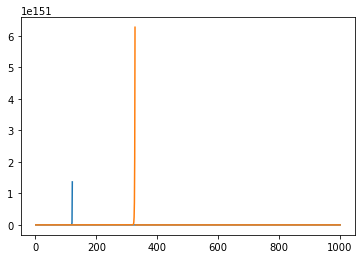

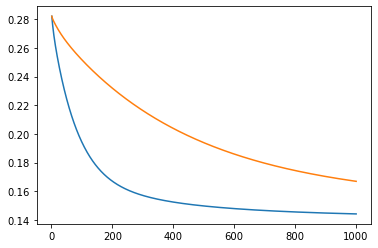

In [43]:
# 12
# Initializing the storage for plotting the gradients 
step_size = [0.5,0.1,0.05,0.01]
num_step = 1000
space2 = np.zeros((num_step, len(step_size)))


theta_1, loss_1 = batch_grad_descent(X_train, y_train, alpha=0.5, num_step= 1000, grad_check=False)
theta_2, loss_2 = batch_grad_descent(X_train, y_train, alpha=0.1, num_step= 1000, grad_check=False)
theta_3, loss_3 = batch_grad_descent(X_train, y_train, alpha=0.05, num_step= 1000, grad_check=False)
theta_4, loss_4 = batch_grad_descent(X_train, y_train, alpha=0.01, num_step= 1000, grad_check=False)


print(loss_1)
print(loss_2)
print(loss_3)

axis = [i for i in range(1,1002)]

plt.figure(1)
plt.plot(axis,loss_1)
plt.plot(axis,loss_2)

plt.figure(2)
plt.plot(axis,loss_3)
plt.plot(axis,loss_4)
plt.show()

In [ ]:
# 13
theta_hist, loss_hist = batch_grad_descent(X_test, y_test, alpha=0.1, num_step= 1000, grad_check=False)


/var/folders/gb/zw91jmc17d950cfmd43jqc7c0000gn/T/ipykernel_1438/4033647080.py:200: RuntimeWarning: overflow encountered in matmul
  grad = (2/np.shape(X)[0])*(X.T@X@theta-X.T@y)+ 2*lambda_reg*theta
/var/folders/gb/zw91jmc17d950cfmd43jqc7c0000gn/T/ipykernel_1438/4033647080.py:54: RuntimeWarning: invalid value encountered in matmul
  loss = (1/np.shape(X)[0])*np.linalg.norm(X@theta-y)
/var/folders/gb/zw91jmc17d950cfmd43jqc7c0000gn/T/ipykernel_1438/4033647080.py:200: RuntimeWarning: overflow encountered in multiply
  grad = (2/np.shape(X)[0])*(X.T@X@theta-X.T@y)+ 2*lambda_reg*theta
/var/folders/gb/zw91jmc17d950cfmd43jqc7c0000gn/T/ipykernel_1438/4033647080.py:228: RuntimeWarning: invalid value encountered in subtract
  theta_hist[i+1,:] = theta_hist[i,:] - alpha * compute_regularized_square_loss_gradient(X, y, theta_hist[i,:], lambda_reg)


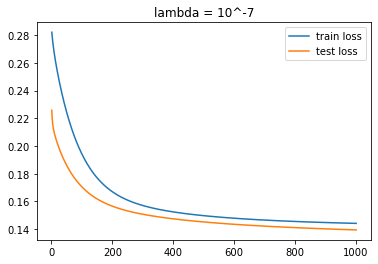

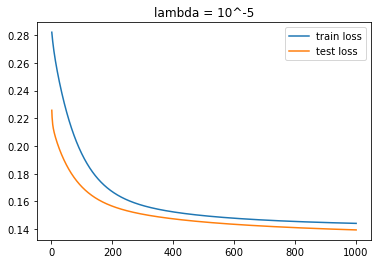

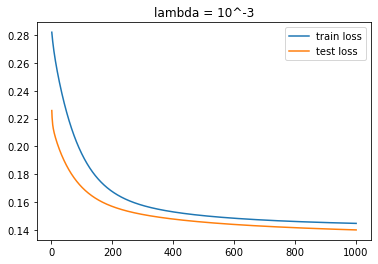

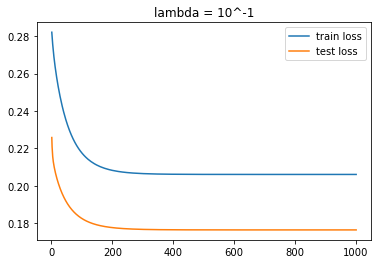

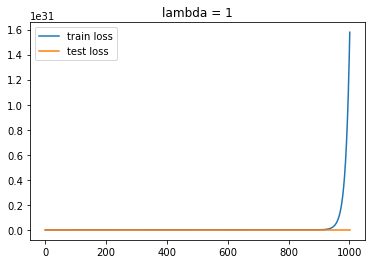

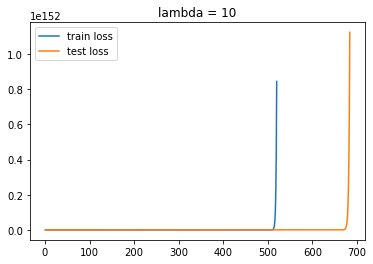

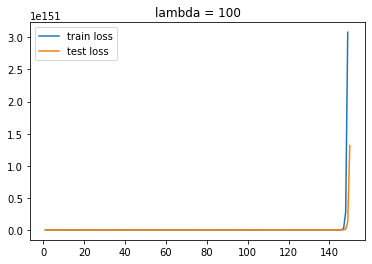

In [47]:
# 17 
lamb = [10**-7,10**-5,10**-3,10**-1,1,10,100]
step_size = 0.05



theta_1, loss_1 = regularized_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=10**-7, num_step=1000)
test_theta_1, test_loss_1 = regularized_grad_descent(X_test, y_test, alpha=0.05, lambda_reg=10**-7, num_step=1000)


theta_2, loss_2 = regularized_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=10**-5, num_step=1000)
test_theta_2, test_loss_2 = regularized_grad_descent(X_test, y_test, alpha=0.05, lambda_reg=10**-5, num_step=1000)

theta_3, loss_3 = regularized_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=10**-3, num_step=1000)
test_theta_3, test_loss_3 = regularized_grad_descent(X_test, y_test, alpha=0.05, lambda_reg=10**-3, num_step=1000)

theta_4, loss_4 = regularized_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=10**-1, num_step=1000)
test_theta_4, test_loss_4 = regularized_grad_descent(X_test, y_test, alpha=0.05, lambda_reg=10**-1, num_step=1000)

theta_5, loss_5 = regularized_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=1, num_step=1000)
test_theta_5, test_loss_5 = regularized_grad_descent(X_test, y_test, alpha=0.05, lambda_reg=1, num_step=1000)

theta_6, loss_6 = regularized_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=10, num_step=1000)
test_theta_6, test_loss_6 = regularized_grad_descent(X_test, y_test, alpha=0.05, lambda_reg=10, num_step=1000)

theta_7, loss_7 = regularized_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=100, num_step=1000)
test_theta_7, test_loss_7 = regularized_grad_descent(X_test, y_test, alpha=0.05, lambda_reg=100, num_step=1000)

# plot
plt.figure(1)
plt.plot([i for i in range(1,1002)],loss_1)
plt.plot([i for i in range(1,1002)],test_loss_1)
plt.title('lambda = 10^-7')
plt.legend(['train loss','test loss'])

plt.figure(2)
plt.plot([i for i in range(1,1002)],loss_2)
plt.plot([i for i in range(1,1002)],test_loss_2)
plt.title('lambda = 10^-5')
plt.legend(['train loss','test loss'])



plt.figure(3)
plt.plot([i for i in range(1,1002)],loss_3)
plt.plot([i for i in range(1,1002)],test_loss_3)
plt.title('lambda = 10^-3')
plt.legend(['train loss','test loss'])



plt.figure(4)
plt.plot([i for i in range(1,1002)],loss_4)
plt.plot([i for i in range(1,1002)],test_loss_4)
plt.title('lambda = 10^-1')
plt.legend(['train loss','test loss'])



plt.figure(5)
plt.plot([i for i in range(1,1002)],loss_5)
plt.plot([i for i in range(1,1002)],test_loss_5)
plt.title('lambda = 1')
plt.legend(['train loss','test loss'])


plt.figure(6)
plt.plot([i for i in range(1,1002)],loss_6)
plt.plot([i for i in range(1,1002)],test_loss_6)
plt.title('lambda = 10')
plt.legend(['train loss','test loss'])

plt.figure(7)
plt.plot([i for i in range(1,1002)],loss_7)
plt.plot([i for i in range(1,1002)],test_loss_7)
plt.title('lambda = 100')
plt.legend(['train loss','test loss'])

plt.show()



[-1.56740547  0.64957411  1.43411523  3.81074791 -3.11313547 -0.44780217
 -0.98535688 -0.98535688  1.29066016  1.46620997  3.83840337 -1.2160442
 -0.6854044  -5.37957372  1.89904081  3.45876795  1.21540316  0.55426064
 -0.06722567 -0.06722567 -0.06722567 -0.0456603  -0.0456603  -0.0456603
 -0.02986982 -0.02986982 -0.02986982 -0.02117431 -0.02117431 -0.02117431
 -0.01591203 -0.01591203 -0.01591203 -0.20196734 -0.20196734 -0.20196734
 -0.02448222 -0.02448222 -0.02448222 -0.01507332 -0.01507332 -0.01507332
 -0.01051537 -0.01051537 -0.01051537 -0.00792837 -0.00792837 -0.00792837
 -1.16239164]


Text(0.5, 1.0, 'test and train_losses')

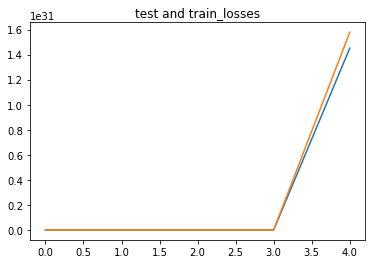

In [70]:
# 18
lamb = [10**-7,10**-5,10**-3,10**-1,1,10,100]
step_size = 0.05

train_losses = [loss_1[-1],loss_2[-1],loss_3[-1],loss_4[-1],loss_5[-1],loss_6[-1],loss_7[-1]]
testloss_1 = compute_square_loss(X_test, y_test, theta_1[-1,:])
testloss_2 = compute_square_loss(X_test, y_test, theta_2[-1,:])
testloss_3 = compute_square_loss(X_test, y_test, theta_3[-1,:])
testloss_4 = compute_square_loss(X_test, y_test, theta_4[-1,:])
testloss_5 = compute_square_loss(X_test, y_test, theta_5[-1,:])
testloss_6 = compute_square_loss(X_test, y_test, theta_6[-1,:])
testloss_7 = compute_square_loss(X_test, y_test, theta_7[-1,:])

testloss = [testloss_1,testloss_2,testloss_3,testloss_4,testloss_5,testloss_6,testloss_7]


axis = [i for i in range(len(testloss))]
plt.figure(1)
plt.plot(axis,testloss)
plt.plot(axis,train_losses)
plt.title('test and train_losses')

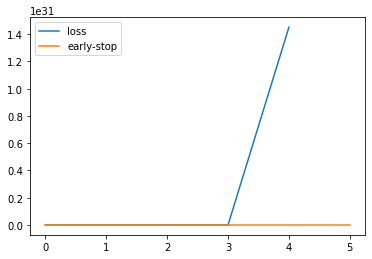

[0.17039417759869976, 0.17037706800576982, 0.16874662995881043, 0.1719799689230193, 1.451135768834675e+31, inf, nan]


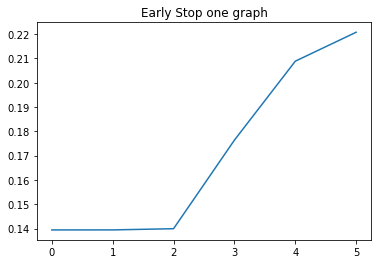

In [69]:
  # 19


loss1_entire  = np.min(test_loss_1)
loss2_entire  = np.min(test_loss_2)
loss3_entire  = np.min(test_loss_3)
loss4_entire  = np.min(test_loss_4)
loss5_entire  = np.min(test_loss_5)
loss6_entire  = np.min(test_loss_6)
loss7_entire  = np.min(test_loss_7)


entire = [loss1_entire,loss2_entire,loss3_entire,loss4_entire,loss5_entire,loss6_entire,loss7_entire]

plt.figure(1)
plt.plot(axis,testloss)
plt.plot(axis,entire)
plt.legend(['loss','early-stop'])
plt.show()


# Early Stop
plt.figure(2)
plt.plot(axis,entire)
plt.title('Early Stop one graph')

print(testloss)
print('10^-3 gives the least loss among all, so we choose 10^-3')

In [ ]:
#20 would use

In [ ]:
# 21

In [95]:
#25
lamb_ans = 10**-3

# For case of fixed step size
# It is possible that the result does not converge


theta_1, loss_1 = stochastic_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=10**-3, num_epoch=1000, eta0=False)
theta_2, loss_2 = stochastic_grad_descent(X_train, y_train, alpha=0.005, lambda_reg=10**-3, num_epoch=1000, eta0=False)

print(loss_1)
print(loss_2)


ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [106]:
# 28

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1')
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test


def sub_sample(N_train, X_train, y_train):
    """
    Subsample the training data to keep only N first elements
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    assert N_train <= X_train.shape[0]
    return X_train[:N_train, :], y_train[:N_train]

def classification_error(clf, X, y):
    # TODO
    y_pred = clf.predict(X)
    err = 0
    for i in range(len(y_pred)):
        if y_pred[i] != y[i]:
            err += 1
    return err/len(y_pred)




In [107]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()

clf = SGDClassifier(loss='log', max_iter=1000, 
                    tol=1e-3,
                    penalty='l1', alpha=0.01, 
                    learning_rate='invscaling', 
                    power_t=0.5,                
                    eta0=0.01,
                    verbose=1)
clf.fit(X_train, y_train)




# test = classification_error(clf, X_test, y_test)
# train = classification_error(clf, X_train, y_train)
# print('train: ', train, end='\t')
# print('test: ', test)

-- Epoch 1
Norm: 0.69, NNZs: 288, Bias: -0.006713, T: 9902, Avg. loss: 0.042017
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 0.78, NNZs: 269, Bias: -0.007579, T: 19804, Avg. loss: 0.032261
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 0.84, NNZs: 251, Bias: -0.007797, T: 29706, Avg. loss: 0.030504
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 0.88, NNZs: 243, Bias: -0.007784, T: 39608, Avg. loss: 0.029635
Total training time: 0.10 seconds.
-- Epoch 5
Norm: 0.92, NNZs: 233, Bias: -0.007634, T: 49510, Avg. loss: 0.028988
Total training time: 0.13 seconds.
-- Epoch 6
Norm: 0.96, NNZs: 223, Bias: -0.007393, T: 59412, Avg. loss: 0.028586
Total training time: 0.16 seconds.
-- Epoch 7
Norm: 0.99, NNZs: 217, Bias: -0.007110, T: 69314, Avg. loss: 0.028228
Total training time: 0.18 seconds.
-- Epoch 8
Norm: 1.01, NNZs: 210, Bias: -0.006798, T: 79216, Avg. loss: 0.027858
Total training time: 0.21 seconds.
Convergence after 8 epochs took 0.21 seconds
train:  0.002019793981013936

(9902, 784)


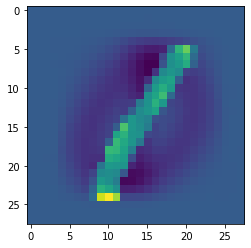

In [105]:
print(np.shape(X_train))
a = X_train[1,:]
b = a.reshape((28,28))
plt.imshow(b)

In [108]:
# 28
test = classification_error(clf, X_test, y_test)
train = classification_error(clf, X_train, y_train)
print('train: ', train, end='\t')
print('test: ', test)

train:  0.0020197939810139365	test:  0.0012300123001230013


In [162]:
# 29
N_train = 100

s_X_train, s_y_train = sub_sample(N_train, X_train, y_train)

In [163]:
alpha = [1e-4,5*1e-4, 8*1e-4,1e-3,3* 1e-3, 2*1e-3,8*1e-2,5*1e-2,3*1e-2,1e-1]
alpha.sort()
print(alpha)

[0.0001, 0.0005, 0.0008, 0.001, 0.002, 0.003, 0.03, 0.05, 0.08, 0.1]


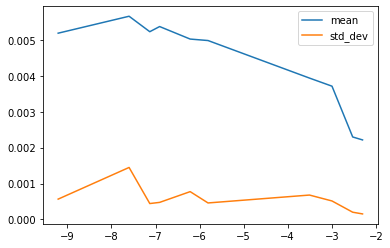

In [168]:
err_mean = np.zeros(10)
err_std = np.zeros(10)
for i,al in enumerate(alpha):
    err_storage = []
    for j in range(10):
        clf = SGDClassifier(loss='log', max_iter=1000, 
                            tol=1e-3,
                            penalty='l1', alpha=al, 
                            learning_rate='invscaling', 
                            power_t=0.5,                
                            eta0=0.01,
                            verbose=0)
        
        clf.fit(s_X_train,s_y_train)
        
        error_one = classification_error(clf,X_test,y_test)
        err_storage.append(error_one)
    err_mean[i] = np.mean(np.array(err_storage))
    err_std[i] = np.std(np.array(err_storage))

axis = np.log(alpha)
plt.errorbar(axis,err_mean)
plt.errorbar(axis,err_std)
plt.legend(['mean','std_dev'])


(1, 784)


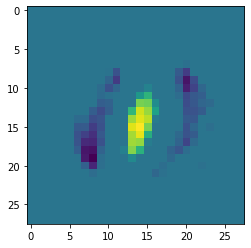

In [175]:
# 30
# For one try for alpha = 10**-1
theta = clf.coef_
print(np.shape(theta))

plt.imshow(redefine)
